In [1]:
import os
import glob
import numpy as np
import pandas as pd
import radio
from radio.batchflow import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB
from radio_utils import show_slices, get_nodules_pixel_coords, num_of_cancerous_pixels
from radio.pipelines import split_dump

# # test d'integration de plaidml. si tout marche bien, generaliser au training
# import plaidml.keras
# plaidml.keras.install_backend()

from config import config
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [32, 32]

# import utils
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/paul/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
PATH_TO_FOLDER = config['luna_raw']
cancerous_folder, non_cancerous_folder = '../jfr_pp/test/positive32', '../jfr_pp/test/negative32'
luna_label = config['luna_label']
    
path_to_scans_sample = os.path.join(PATH_TO_FOLDER, '*.mhd')
luna_index = FilesIndex(path=path_to_scans_sample, no_ext=True)
lunaset = Dataset(index=luna_index, batch_class=CTIMB)
print(len(luna_index.indices))
lunaset.split([0.8,0.1,0.1])
print(len(lunaset.test))

884
88


In [3]:
nodules_df = pd.read_csv(luna_label)

In [17]:
from radio.models import Keras3DUNet
from radio.models.keras.losses import dice_loss

config = dict(load=dict(filepath='./model/test.h5'), build='first', loss=dice_loss, input_shape=(1,32,64,64))

res_pipe = (
    Pipeline()
    .init_model('static', Keras3DUNet, '3dunet', config)
    .load(fmt='raw')  # load scans
    .normalize_hu(-1000, 400)  # normalize hu
    .fetch_nodules_info(nodules=nodules_df)  # load nodules locations
    .unify_spacing(shape=(351, 370, 370), spacing=(1., 1., 1.))
    .predict_on_scan(
        '3dunet',
        model_type='keras',
        strides=(16, 32, 32),
        crop_shape=(32,64,64),
        batch_size=4,
        data_format='channels_first',
        targets_mode='segmentation',
        show_progress=True)
)

In [57]:
%%time

batch = (lunaset.test >> res_pipe).next_batch(1)


CPU times: user 4h 35min 4s, sys: 21min 7s, total: 4h 56min 11s
Wall time: 20min 29s


In [59]:
batch.masks = np.nan_to_num(batch.masks)
print(batch.num_nodules)
num_of_cancerous_pixels(batch)

2


,Scan 0
Number of cancerous pixels:,0


In [61]:
batch = batch.fetch_nodules_from_mask()

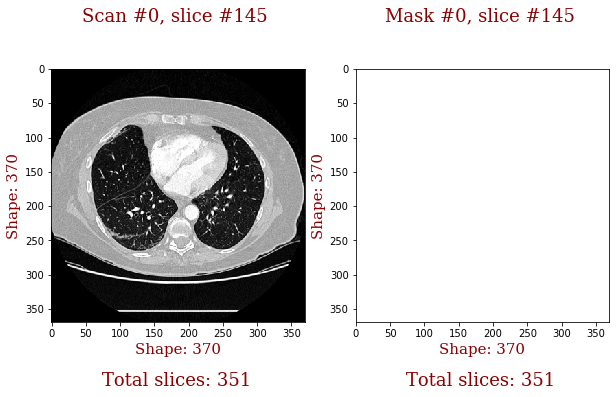

In [41]:
show_slices(batch, 0, 145, components=['images', 'masks'], clims=[(0, 255), (0, 1)],
            grid=False)